In [451]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import CSS4_COLORS
from scipy.stats import chi2_contingency

## Importação dos dados

*obs: para funcionar corretamente, certificar que o arquivo esteja no diretório correto*

In [303]:
path='Exercicio_Python_CRM.xlsx'

transactions = pd.read_excel(path, sheet_name="Transações")
produtos = pd.read_excel(path, sheet_name="Produto")
lojas = pd.read_excel(path, sheet_name="Lojas")
clientes = pd.read_excel(path, sheet_name="Cliente").rename(columns={'CustomerID': 'ID_Cliente'})
teste = pd.read_excel(path, sheet_name="Teste")

In [304]:
#Preparando o df produtos

produtos['Descrição Produto'] = produtos['Categoria'].str.cat([produtos['Cor'], produtos['Marca']], sep=' ')
produtos

,ID_Produto,Descrição Produto,Categoria,Cor,Marca
0,123000,Bottom Azul AlfaX,Bottom,Azul,AlfaX
1,123001,Top Cinza GammaZ,Top,Cinza,GammaZ
2,123002,Bottom Preto BetaY,Bottom,Preto,BetaY
3,123003,Top Vermelho BetaY,Top,Vermelho,BetaY
4,123004,Top Cinza BetaY,Top,Cinza,BetaY
5,123005,Top Cinza AlfaX,Top,Cinza,AlfaX
6,123006,Bottom Preto AlfaX,Bottom,Preto,AlfaX
7,123007,Top Vermelho AlfaX,Top,Vermelho,AlfaX
8,123008,Top Vermelho GammaZ,Top,Vermelho,GammaZ
9,123009,Top Vermelho GammaZ,Top,Vermelho,GammaZ


In [305]:
#Preparando o df lojas

lojas['UF'] = lojas['UF'].str.strip().replace('BH','BA')

uf_regiao_map = {'AM': 'NORTE', 'MG': 'SUDESTE', 'SP': 'SUDESTE', 'RS': 'SUL', 'BA': 'NORDESTE'}

lojas['Regiao'] = lojas.apply(lambda row: uf_regiao_map.get(row['UF']) if pd.isna(row['Regiao']) or row['Regiao'] not in uf_regiao_map.values() else row['Regiao'], axis=1)

lojas

,ID_Loja,UF,Regiao
0,1,AM,NORTE
1,2,MG,SUDESTE
2,3,SP,SUDESTE
3,4,SP,SUDESTE
4,5,SP,SUDESTE
5,6,SP,SUDESTE
6,7,RS,SUL
7,8,RS,SUL
8,9,BA,NORDESTE
9,10,BA,NORDESTE


In [306]:
#Gasto por cliente

transactions_gb = transactions[['ID_Cliente','ValorTotal']].groupby('ID_Cliente').sum()
transactions_gb.mean()

ValorTotal    8892.123545
dtype: float64

# Criando os KPIs

## Ticket médio

<Axes: xlabel='Data', ylabel='ValorTotal'>

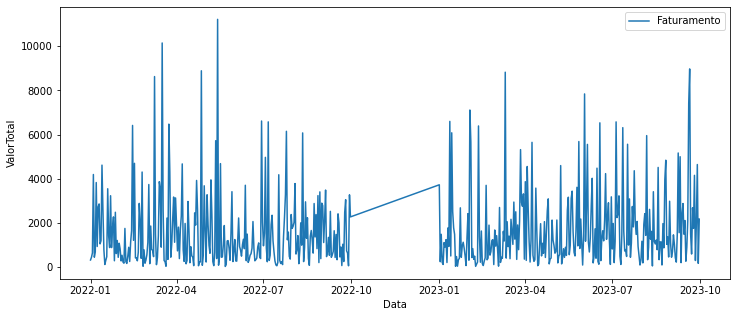

In [307]:
#Faturamento por Data
transactions_gb = transactions[['Data','ValorTotal']].groupby('Data').sum()
transactions_gb

plt.figure( figsize = ( 12, 5)) 
sns.lineplot( x = 'Data', 
             y = 'ValorTotal', 
             data = transactions_gb, 
             label = 'Faturamento') 

<Axes: xlabel='Data', ylabel='ValorTotal'>

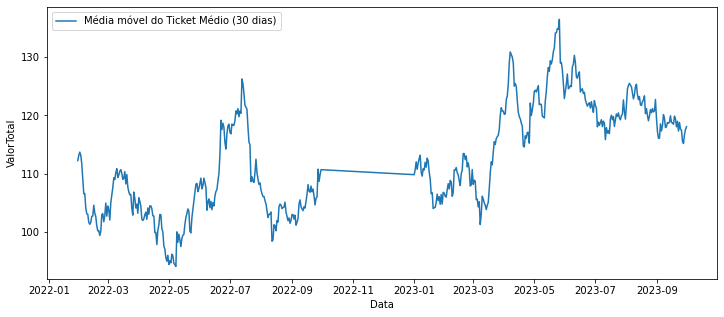

In [308]:
#Media móvel do ticket médio

transactions = transactions.sort_values(by='Data')

ticket_medio = transactions.groupby('Data').mean()['ValorTotal']

media_movel = ticket_medio.rolling(30).mean()

#Gráfico de linha
plt.figure( figsize = ( 12, 5)) 
sns.lineplot( x = media_movel.index,
             y= media_movel,
             label = 'Média móvel do Ticket Médio (30 dias)')


#### Conclusões

Aplicando a média móvel no ticket médio, obtivemos uma visualização mais suave e agora conseguimos visualizar melhor as tendências no gráfico.

Nota-se que houve uma tendência crescente do ticket médio de um ano ao outro, com altos picos locais em 2022-07, 2023-04 e 2023-06. Vemos também um comportamento anômalo entre 2022-10 e 2023-01, o que cabe procurar entender a sua justificativa.

## Faturamento por Produto

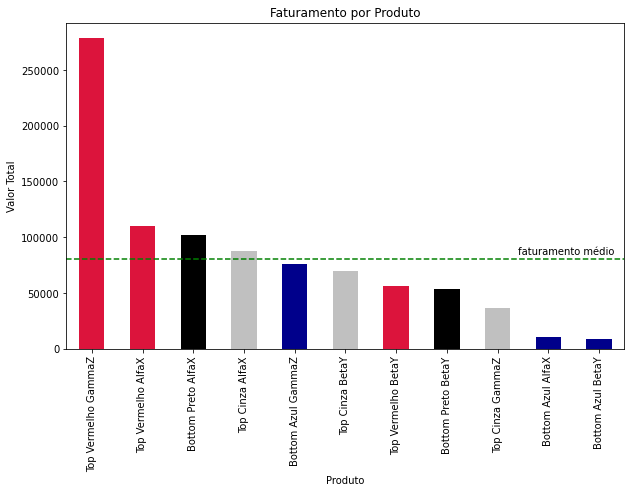

In [391]:


count_produtos = transactions[['ID_Produto','UnidadesVendidas','ValorTotal']].groupby('ID_Produto').sum().sort_values(by='ValorTotal',ascending=False)
count_produtos = pd.merge(count_produtos, produtos, how='inner', on='ID_Produto')



grupo_produto = count_produtos.groupby(['Descrição Produto','Cor']).sum().sort_values(by='ValorTotal',ascending=False)
grupo_produto.reset_index(level='Cor', inplace=True)

fat_médio = grupo_produto['ValorTotal'].mean()

# Gráfico de barras
# Colorindo cada barra com a cor respectiva do produto
map_cores = {'Vermelho': 'crimson', 'Verde': 'green', 'Azul': 'darkblue', 'Amarelo': 'yellow', 'Roxo': 'purple', 'Cinza': 'silver'}
grupo_produto['Cor'] = grupo_produto['Cor'].map(map_cores)
cores_hex = [CSS4_COLORS.get(cor, 'black') for cor in grupo_produto['Cor']]

grupo_produto['ValorTotal'].plot(kind='bar', color=cores_hex, figsize=(10, 6))
plt.axhline(y=fat_médio, color='green', linestyle='--')
plt.text(10.3, fat_médio+2000, 'faturamento médio', color='black', ha='right', va='bottom')
#plt.text(0.3, fat_comTrat-10000, f'Faturamento {ganho_com_trat}x maior', color='black', ha='left', va='bottom', fontsize=13)
plt.title('Faturamento por Produto')
plt.xlabel('Produto')
plt.ylabel('Valor Total')
plt.show()

#### Conclusões

Vemos que o produto Top Vermelho GammaZ é o que traz o maior faturamento e os produtos Bottom Azul são os que trazem o menor faturamento.

## Faturamento por Loja

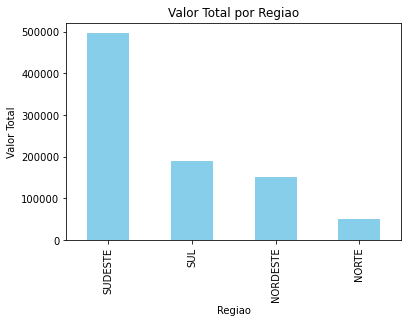

In [328]:

count_loja = transactions[['ID_Loja','UnidadesVendidas','ValorTotal']].groupby('ID_Loja').sum().sort_values(by='ValorTotal',ascending=False)
count_loja = pd.merge(count_loja, lojas, how='inner', on='ID_Loja')[['ID_Loja', 'ValorTotal', 'UnidadesVendidas', 'UF', 'Regiao']]


# Gráfico de barras
grupo_regiao = count_loja.groupby('Regiao').sum().sort_values(by='ValorTotal',ascending=False)
grupo_regiao['ValorTotal'].plot(kind='bar', color='skyblue')
plt.title('Valor Total por Regiao')
plt.xlabel('Regiao')
plt.ylabel('Valor Total')
plt.show()

#### Conclusões
Com esse gráfico podemos avaliar o faturamento em cada região do país.

## Frequência

In [329]:
# Frequência média de cada cliente (Tempo médio que os clientes demoram para retornar para uma nova compra)

transactions.sort_values(by=['ID_Cliente', 'Data'], inplace=True)

transactions['Diferenca_tempo'] = transactions.groupby('ID_Cliente')['Data'].diff()

tempo_medio_retorno = transactions.groupby('ID_Cliente').mean()[['Diferenca_tempo']]

tempo_medio_retorno['Diferenca_dias'] = tempo_medio_retorno['Diferenca_tempo'].dt.days

tempo_medio_retorno.drop(columns=['Diferenca_tempo'], inplace=True)

#Mesclar com a tabela Clientes
tempo_medio_retorno = pd.merge(tempo_medio_retorno, clientes, how='inner', on='ID_Cliente')
tempo_medio_retorno.sort_values(by=['Diferenca_dias'], inplace=True)
tempo_medio_retorno

,ID_Cliente,Diferenca_dias,Genero,FaixaIdade,ClasseSocial
83,90083,6,Feminino,35-45,D
94,90094,6,Masculino,25-35,C
3,90003,6,Feminino,45+,C
31,90031,6,Feminino,25-35,E
89,90089,6,Masculino,18-25,C
...,...,...,...,...,...
42,90042,11,Masculino,25-35,C
10,90010,11,Masculino,45+,B
20,90020,12,Feminino,25-35,D
0,90000,15,Feminino,35-45,C


#### Conclusões
Com esse Dataframe podemos avaliar se há diferença na frequência dos clientes e podemos relacioná-la a recortes específicos de Gênero, Faixa etária e classe social.

## Campanha do Top Vermelho GammaZ

Para avaliar a eficação do tratamento conferido ao produto Top Vermelho GammaZ no ano de 2023, primeiro precisamos encontrar a medida: Unidade Vendida de cada Produto por Ano

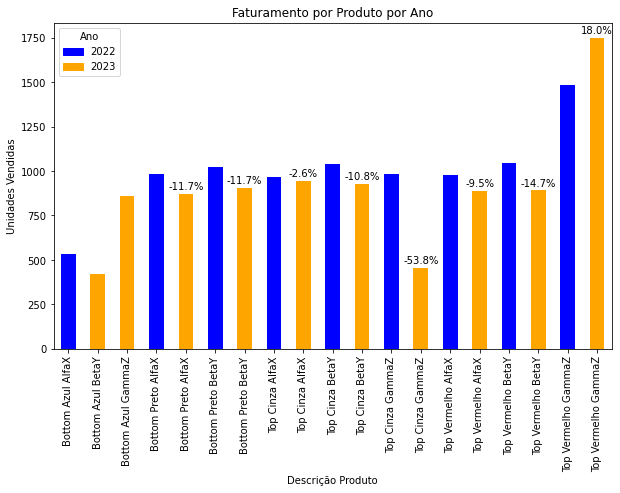

In [450]:
transactions['Ano'] = transactions['Data'].dt.year
df = transactions[['ID_Produto', 'Ano', 'UnidadesVendidas', 'ValorTotal']]

# Agrupando primeiro pelo ano e depois pelo produto
count_produtos = pd.merge(df, produtos, how='inner', on='ID_Produto')[['Ano', 'UnidadesVendidas','ValorTotal','Descrição Produto']]
count_produtos = count_produtos.groupby(['Ano', 'Descrição Produto']).agg({
    'UnidadesVendidas': 'sum',
    'ValorTotal': 'sum'
}).reset_index()

count_produtos = count_produtos.sort_values(by='UnidadesVendidas',ascending=True).sort_values(by='Ano',ascending=True).sort_values(by='Descrição Produto',ascending=True)

#Gráfico de barra

cores = {2022: 'blue', 2023: 'orange'}
count_produtos.index = count_produtos['Descrição Produto']
count_produtos = count_produtos.drop('Descrição Produto', axis=1)
ax = count_produtos['UnidadesVendidas'].plot(kind='bar', color=count_produtos['Ano'].map(cores), figsize=(10, 6))
legendas = [plt.Rectangle((0, 0), 1, 1, color=cores[ano], label=ano) for ano in df['Ano'].unique()]
plt.legend(handles=legendas, title='Ano')
plt.title('Faturamento por Produto por Ano')

#Adicionar a diferença percentual de um ano ao outro de unidades vendidas

count_produtos['Diff_Pct'] = round(count_produtos.groupby('Descrição Produto')['UnidadesVendidas'].pct_change() * 100,1)

for i, v_unidades, v_diff_pct in zip(range(len(count_produtos)), count_produtos['UnidadesVendidas'], count_produtos['Diff_Pct']):
    if not pd.isna(v_diff_pct):
        ax.text(i, v_unidades + 70, f'{v_diff_pct}%', ha='center', va='top', color='black')
        
plt.ylabel('Unidades Vendidas')
plt.show()

#### Resultados da campanha ao produto Top Vermelho GammaZ

Avaliando as unidades vendidas de cada produto, registrou-se uma quantidade maiore para o Top Vermelho GammaZ quando comparado com as quantidades dos demais produtos. 

O mais importante aqui é ver que de 2022 a 2023 houve queda na quantidade vendida em todos os produtos, exceto para o Top Vermelho GammaZ, que teve um aumento de 18% de um ano ao outro na quantidade vendida. Isso é um forte indício de que a campanha para esse produto em específico teve eficácia.


## Novo sistema de recomendação


Para comparar se há diferença entre os grupos "teste" e "controle" em relação à coluna de resposta (0 ou 1), podemos usar o teste estatístico Teste Qui-Quadrado, que é adequado para variáveis não contínuas (0 ou 1).

Para o Teste Qui-Quadrado ser adequado, devemos escolher a nossa variável resposta de forma que a distribuição das contagens nas categorias seja a mais uniforme possível(contagens iguais de 0 e 1). Considerando isso, a variável resposta escolhida para a análise foi a da coluna 'Comprou'.

Com esse teste, objetivamos inferir com uma confiança determinada(95%) se há influência do novo modelo de recomendação no comportamento dos clientes(se eles em média compraram mais ou não).

Faremos o seguinte teste de Hipótese:

Hipótese Nula (H0): Não há associação entre as variáveis 'Grupo' e 'Comprou', ou seja, são independentes.

Hipótese Alternativa (H1): Há uma associação significativa entre as variáveis.



In [453]:
contingency_table = pd.crosstab(teste['Grupo'], teste['Comprou'])
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f'Chi-squared value: {chi2}')
print(f'p-value: {p}')

Chi-squared value: 2.293358815097947
p-value: 0.12992848196908097


### Resultados


Como o valor-p é grande(maior que o estipulado de 0.05), não temos evidências para rejeitar a hipótese nula.

Um erro aqui seria concluirmos que não há uma associação significativa entre as variáveis. Contudo, quando não rejeitamos H0, não necessariamente podemos descartar H1. Portanto o experimento é apenas inconclusivo.

Para realmente termos conclusões estatisticamente significativas, uma possível solução seria aumentar o tamanho da amostra para aumentar o poder estatístico do teste, e avaliar novamente os dados procurando por padrões ou fatores que possam estar causando essa inconclusividade. Ainda, poderíamos procurar por outros modelos estatísticos que funcionem melhor para o nosso experimento.

###### Notebook criado por Guilherme Borsari

www.linkedin.com/in/guilherme-borsari/